<a href="https://colab.research.google.com/github/Barthof/ImageMiningTeamB/blob/main/Model_from_scratch_Citrus_leaves_image_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
# Install imbalance learning library
!pip install imblearn

In [ ]:
# Load dataset with info and
# split first 60% of dataset into train_ds and the other two 20% into test_ds and val_ds
(train_ds, test_ds, val_ds), info = tfds.load('citrus_leaves', as_supervised=True, with_info=True, split=["train[:60%]", "train[60%:80%]", "train[80%:]"], shuffle_files=True, batch_size=-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/citrus_leaves/0.1.1.incompleteKXATMF/citrus_leaves-train.tfrecord


  0%|          | 0/594 [00:00<?, ? examples/s]

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
# Split images and labels
image_train, label_train = tfds.as_numpy(train_ds)
image_test, label_test = tfds.as_numpy(test_ds)
image_val, label_val = tfds.as_numpy(val_ds)

In [ ]:
print(image_train.shape)
print(image_test.shape)
print(image_val.shape)
print(label_train.shape) 
print(label_test.shape)
print(label_val.shape)

(356, 256, 256, 3)
(119, 256, 256, 3)
(119, 256, 256, 3)
(356,)
(119,)
(119,)


Shape of image_train: (446, 256, 256, 3)

Shape of label_train: (446,)

Shape of image_test: (148, 256, 256, 3)

Shape of label_test: (148,)

In [ ]:
# Print matrix of image at index 0
print(image_train[0])

[[[217 202 203]
  [218 202 204]
  [220 204 205]
  ...
  [195 186 203]
  [192 186 201]
  [192 185 201]]

 [[218 203 203]
  [219 204 204]
  [220 204 205]
  ...
  [196 187 204]
  [192 185 200]
  [192 185 201]]

 [[218 204 204]
  [219 204 205]
  [220 204 205]
  ...
  [195 185 202]
  [194 186 203]
  [194 187 202]]

 ...

 [[ 76  51  25]
  [ 87  61  32]
  [ 91  62  38]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 62  39  16]
  [ 85  60  34]
  [100  72  45]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 56  35  18]
  [ 68  45  22]
  [102  76  48]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


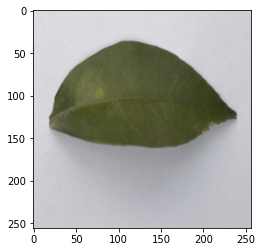

In [ ]:
# Display image
plt.imshow(image_train[1])

In [ ]:
# Extract informative features
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print("Class names:", class_names)
print("Number of classes:", n_classes)
print("Size of training set:", len(image_train))
print("Unique labels in training set:", np.unique(label_train)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']
print("Size of test set:", len(image_test))
print("Unique labels in test set:", np.unique(label_test)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']

Class names: ['Black spot', 'canker', 'greening', 'healthy']
Number of classes: 4
Size of training set: 356
Unique labels in training set: [0 1 2 3]
Size of test set: 119
Unique labels in test set: [0 1 2 3]


In [ ]:
# amount per label in training set
# {0: 127, 1: 126, 2: 147, 3: 46}
print("training:", dict(sorted(Counter(label_train).items())))
# amount per label in test set
# {0: 42, 1: 37, 2: 57, 3: 12}
print("test:", dict(sorted(Counter(label_test).items())))

training: {0: 105, 1: 101, 2: 113, 3: 37}
test: {0: 32, 1: 29, 2: 47, 3: 11}


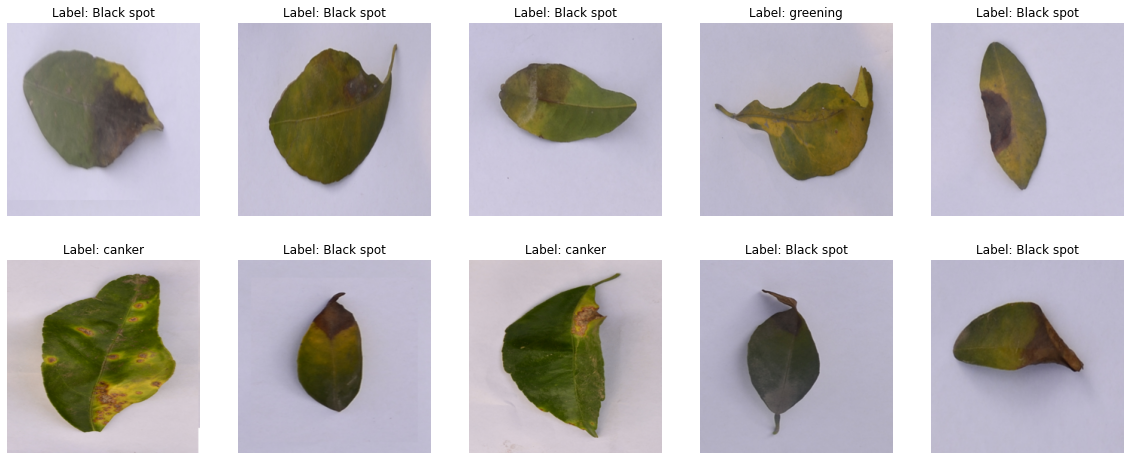

In [ ]:
import matplotlib.pyplot as plt

num_samples = 10

rand_samples = np.random.choice(np.arange(image_train.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_train[rand_samples[i]]
    label = label_train[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

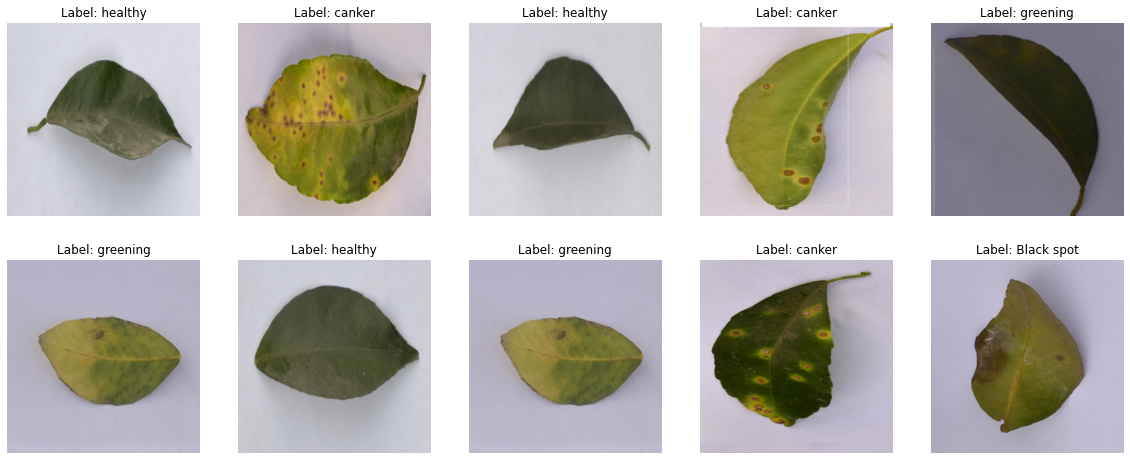

In [ ]:
num_samples = 10

rand_samples = np.random.choice(np.arange(image_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_test[rand_samples[i]]
    label = label_test[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

# Preprocessing

**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator as IDG

idg_train = IDG(
    rotation_range=180,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

idg_train.fit(image_train)

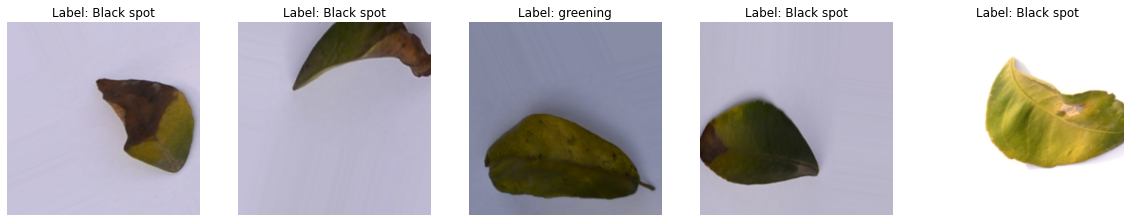

In [ ]:
fig = plt.figure(figsize=(20, 8))
for augmented_train, augmented_label in idg_train.flow(image_train, label_train, batch_size=-1):
    for i in range(0, 5):
        #plt.subplot()
        ax = fig.add_subplot(2, 5, i+1)
        label = augmented_label[i]
        class_label = class_names[label]
        ax.set_title(f"Label: {class_label}")
        ax.axis('off')
        augmented_train = augmented_train.astype('uint8')
        ax.imshow(augmented_train[i].reshape(256, 256, 3))
    break
plt.show()

In [ ]:
print(len(augmented_label))
# amount per label in augmented train set
# {0: 127, 1: 126, 2: 146, 3: 46}
print("augmented:", dict(sorted(Counter(augmented_label).items())))

355
augmented: {0: 105, 1: 100, 2: 113, 3: 37}


In [ ]:
image_train.shape, augmented_train.shape

((356, 256, 256, 3), (355, 256, 256, 3))

In [ ]:
# Append augmented data to original dataset
X_train = np.concatenate((image_train, augmented_train))
y_train = np.concatenate((label_train, augmented_label))

**Oversampling using SMOTE**

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

# Import SMOTE from imblearn library
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

0.8.1


Class=0, n=210 (29.536%)
Class=1, n=201 (28.270%)
Class=2, n=226 (31.786%)
Class=3, n=74 (10.408%)


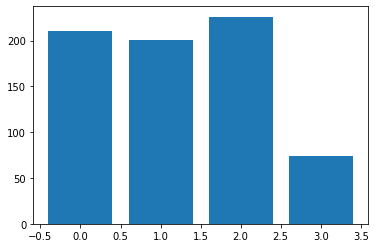

In [ ]:
# summarize distribution
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Reshape X_train data first**
*   First Flatten the image
*   Apply SMOTE on this flattened image data and its labels
*   Reshape the flattened image to RGB image

In [ ]:
from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42)
    
train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,256,256,3)

In [ ]:
# Print new shapes
print(X_train.shape) # (904, 256, 256, 3)
print(y_train.shape) # (904, 2)

(904, 256, 256, 3)
(904,)


Class=0, n=226 (25.000%)
Class=1, n=226 (25.000%)
Class=2, n=226 (25.000%)
Class=3, n=226 (25.000%)


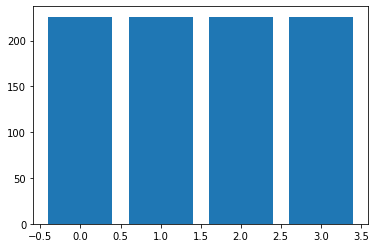

In [ ]:
# Summarize distribution after Smote
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Fix the name of other val and test data sett**

In [ ]:
# Fix the name and check the shape of validation images
X_val = image_val
print(X_val.shape)
# Fix the name and check the shape of test images
X_test = image_test
print(X_test.shape)

(119, 256, 256, 3)
(119, 256, 256, 3)


**Normalize data**

In [ ]:
X_train=X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [ ]:
#print(X_train[0])
print(X_val[0])

[[[0.81568627 0.77647059 0.81176471]
  [0.81960784 0.78039216 0.81568627]
  [0.81176471 0.77254902 0.80784314]
  ...
  [0.79607843 0.75686275 0.78823529]
  [0.78431373 0.75294118 0.78431373]
  [0.78823529 0.75294118 0.78823529]]

 [[0.81176471 0.77254902 0.80784314]
  [0.80784314 0.76862745 0.80392157]
  [0.81568627 0.77647059 0.81176471]
  ...
  [0.78823529 0.75294118 0.79215686]
  [0.78039216 0.74901961 0.79215686]
  [0.78039216 0.74901961 0.79215686]]

 [[0.81568627 0.77647059 0.81176471]
  [0.81176471 0.77254902 0.80784314]
  [0.81176471 0.77254902 0.81176471]
  ...
  [0.78823529 0.74509804 0.78823529]
  [0.78039216 0.74117647 0.78431373]
  [0.78039216 0.74117647 0.78431373]]

 ...

 [[0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  ...
  [0.77647059 0.72941176 0.79215686]
  [0.78431373 0.74117647 0.79607843]
  [0.78431373 0.74117647 0.8       ]]

 [[0.76470588 0.7254902  0.78823529]
  [0.75686275 0.7254902  0.78431373]


**One Hot Encoding**

In [ ]:
# One hot encoder labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(label_val.reshape(-1, 1)).toarray()
y_test = enc.transform(label_test.reshape(-1, 1)).toarray()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(904, 4)
(119, 4)
(119, 4)


# Creating a Model

One requirement of the neural network model was to define the input shape, hence, all the images needed to in the same shape.

In [ ]:
X_train.shape

(904, 256, 256, 3)

In [ ]:
input_shape = X_train[0].shape

**Define the model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers as rg
from tensorflow.keras import initializers as it

model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape,padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 64)      

**Apply early stopping to avoid overfitting**

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)


**Model Training and fitting**

Used Adam as optimizer, Categorical Cross Entropy as Loss

Hyper Parameters

    Learning Rate - 0.0001



In [ ]:
adam=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    shuffle = True,
)

Epoch 1/30
29/29 [==============================] - 4s 101ms/step - loss: 1.3754 - accuracy: 0.2954 - val_loss: 1.3819 - val_accuracy: 0.3277
Epoch 2/30
29/29 [==============================] - 3s 90ms/step - loss: 1.3139 - accuracy: 0.3485 - val_loss: 1.3029 - val_accuracy: 0.3025
Epoch 3/30
29/29 [==============================] - 3s 89ms/step - loss: 1.2095 - accuracy: 0.4469 - val_loss: 1.0797 - val_accuracy: 0.5630
Epoch 4/30
29/29 [==============================] - 3s 89ms/step - loss: 1.0778 - accuracy: 0.5044 - val_loss: 1.0045 - val_accuracy: 0.5714
Epoch 5/30
29/29 [==============================] - 3s 96ms/step - loss: 0.9829 - accuracy: 0.5841 - val_loss: 0.9109 - val_accuracy: 0.5798
Epoch 6/30
29/29 [==============================] - 3s 89ms/step - loss: 0.9431 - accuracy: 0.6062 - val_loss: 0.9029 - val_accuracy: 0.5378
Epoch 7/30
29/29 [==============================] - 3s 89ms/step - loss: 0.8809 - accuracy: 0.6361 - val_loss: 0.7912 - val_accuracy: 0.6891
Epoch 8/30
2

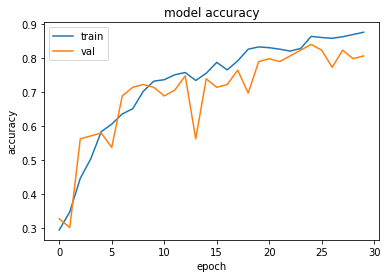

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

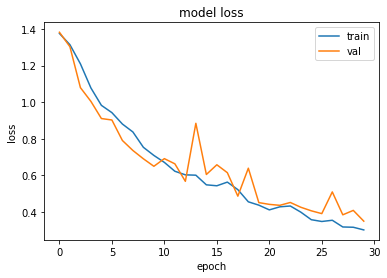

In [ ]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Evaluate the generated Model (Testing)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 42ms/step - loss: 0.4807 - accuracy: 0.7647


[0.4807017147541046, 0.7647058963775635]

# Prediction for creating a Confusion matrix

In [ ]:
result=model.predict(X_test)

In [ ]:
result

array([[6.68888837e-02, 8.25758636e-01, 1.07284822e-01, 6.76181735e-05],
       [9.75395367e-02, 8.74731600e-01, 2.08452400e-02, 6.88357558e-03],
       [2.13176802e-01, 3.19638290e-03, 7.83577800e-01, 4.89772319e-05],
       [6.89129591e-01, 3.90108980e-05, 3.07135522e-01, 3.69581720e-03],
       [5.55861950e-01, 2.25009659e-04, 4.42513138e-01, 1.39993231e-03],
       [1.52087235e-03, 1.54720747e-05, 5.75853155e-05, 9.98406112e-01],
       [6.74523134e-03, 2.23898369e-05, 2.14518019e-04, 9.93017912e-01],
       [2.44986396e-02, 9.48886693e-01, 2.37504467e-02, 2.86422158e-03],
       [1.10041067e-01, 7.32966186e-03, 8.82570922e-01, 5.83775545e-05],
       [4.05153371e-02, 7.25755172e-07, 9.59473670e-01, 1.03378052e-05],
       [6.95236376e-04, 7.85329485e-06, 3.27973576e-05, 9.99264181e-01],
       [2.00374168e-03, 9.94696379e-01, 5.36080461e-06, 3.29447677e-03],
       [6.69571102e-01, 2.29692505e-05, 3.28075022e-01, 2.33089947e-03],
       [8.41905296e-01, 5.32330363e-04, 1.54160857e

In [ ]:
result[0]

array([6.6888884e-02, 8.2575864e-01, 1.0728482e-01, 6.7618173e-05],
      dtype=float32)

In [ ]:
# Get the index of prediction 

y_true=[]
y_pred=[]
for i in range(len(result)):
    y_true.append(np.argmax(y_test[i]))
    y_pred.append(np.argmax(result[i]))

In [ ]:
print('True label', y_true)
print('Pred label:', y_pred)

True label [2, 1, 2, 0, 2, 3, 3, 1, 0, 2, 3, 1, 0, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 2, 2, 3, 3, 1, 0, 1, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 0, 3, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 3, 2, 1, 2, 2, 2, 0, 0, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 2]
Pred label: [1, 1, 2, 0, 0, 3, 3, 1, 2, 2, 3, 1, 0, 0, 1, 2, 3, 1, 1, 2, 1, 0, 0, 3, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 3, 2, 3, 2, 3, 3, 1, 2, 1, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 3, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 3, 1, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 3, 2, 1, 2, 0, 2, 0, 0, 0, 3, 2, 0, 1, 2, 0, 0, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 3, 0]


In [ ]:
np.unique(y_true),np.unique(y_pred)

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Confusion Matrix

In [ ]:
len(y_test)

119

In [ ]:
mat=confusion_matrix(y_true, y_pred)
mat

array([[18,  0, 14,  0],
       [ 0, 29,  0,  0],
       [ 9,  1, 33,  4],
       [ 0,  0,  0, 11]])

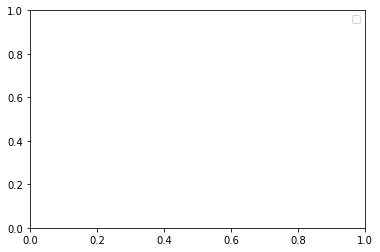

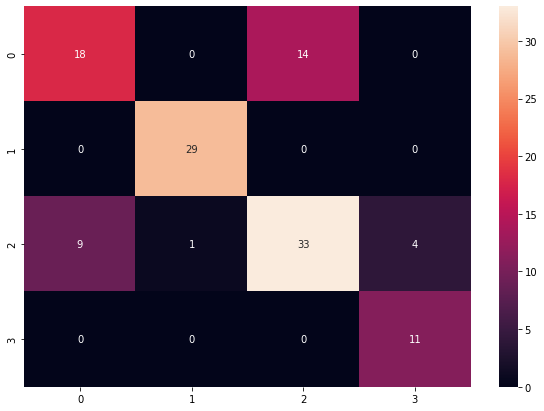

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

classes = ["0","1", "2", "3"]

'''
"0"--> label Black Spot
"1"--> label Canker
"2"--> label Greening
"3"--> label Healthy
'''


df_cfm = pd.DataFrame(mat, index = classes, columns = classes)
plt.legend(['Black Spot', 'Canker', 'Greening', 'Healthy'])
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
#cfm_plot.figure.savefig('/content/gdrive/MyDrive/result_CNN_1_5_REV/confusion_matrix.png')
plt.show()
#true y axis
# pred x axis

# Score of each class

In [ ]:
score_each_class=[]
temp=[]
for i in range(len(mat)):
    temp_sum=sum(mat[i])
    
    for j in range(len(mat[i])):
        temp.append(mat[i][j]/temp_sum)
    score_each_class.append(temp)
    temp=[]
    
score_each_class

[[0.03125, 0.0, 0.90625, 0.0625],
 [0.034482758620689655, 0.7586206896551724, 0.20689655172413793, 0.0],
 [0.02127659574468085, 0.0, 0.851063829787234, 0.1276595744680851],
 [0.0, 0.0, 0.0, 1.0]]

# Precision, Recall and F1-score

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_true, y_pred, average='macro')

0.7671985815602838

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='macro')

0.816156914893617

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.7853754611778412